In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, TimeDistributed, GlobalAveragePooling2D,
                                     Dense, LSTM, Multiply, Dropout, Flatten, Lambda)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
from twilio.rest import Client

In [5]:
dataset_path = r"C:\Users\mgree\Downloads\Dataset CAUCAFall\Dataset CAUCAFall\CAUCAFall"

In [ ]:
def video_frame_generator(video_path, action_type, batch_size=4):
    cap = cv2.VideoCapture(video_path)
    frames_batch = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))  
        frames_batch.append(frame)

        if len(frames_batch) == batch_size:
            yield np.array(frames_batch), action_type
            frames_batch = []  

    if len(frames_batch) > 0:
        yield np.array(frames_batch), action_type

    cap.release()


def load_dataset(dataset_path, batch_size=4):
    data = []  
    labels = []  
    actions = []  
    

    for subject in os.listdir(dataset_path):
        subject_path = os.path.join(dataset_path, subject)
        
        
        if not os.path.isdir(subject_path):
            continue
        
        for action in os.listdir(subject_path):
            action_path = os.path.join(subject_path, action)
            
            if not os.path.isdir(action_path):
                continue
            
            action_type = action.split("_")[0]  
            
            
            for video_file in os.listdir(action_path):
                if video_file.endswith(".avi"): 
                    video_path = os.path.join(action_path, video_file)
                    
                    frame_generator = video_frame_generator(video_path, action_type, batch_size)
                    
                    for frames_batch, action in frame_generator:
                        data.append(frames_batch)
                        labels.append(1 if "Fall" in action else 0)
                        actions.append(action)

    return data, labels, actions

def flatten_data(data, labels):
    X_flattened = []
    y_flattened = []

    for seq, label in zip(data, labels):
        for frame_batch in seq:
            X_flattened.append(frame_batch)  
            y_flattened.append(label)  
    
    return np.array(X_flattened), np.array(y_flattened)


data, labels, actions = load_dataset(dataset_path, batch_size=4)
print(f"Total number of video sequences: {len(data)}")
print(f"Actions found in the dataset: {set(actions)}")

X_flattened, y_flattened = flatten_data(data, labels)
y_flattened = to_categorical(y_flattened, num_classes=2)

X_train, X_test, y_train, y_test = train_test_split(X_flattened, y_flattened, test_size=0.2, random_state=42)
print(f"Training data size: {len(X_train)} frames")
print(f"Test data size: {len(X_test)} frames")


Total number of video sequences: 5006
Actions found in the dataset: {'Fall right', 'Fall left', 'Fall backwards', 'Fall forward', 'Sit down', 'Walk', 'Kneel', 'Pick up object', 'Fall sitting', 'Hop'}
Training data size: 15901 frames
Test data size: 3976 frames


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    
    return model

input_shape = (224, 224, 3)
model_traditional = create_cnn_model(input_shape)
model_traditional.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_traditional.summary()

c:\Users\mgree\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, Multiply, Input
from tensorflow.keras.models import Model


def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1  
    filters = init.shape[channel_axis]
    
    se = GlobalAveragePooling2D()(init)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape([1, 1, filters])(se)
    
    x = Multiply()([init, se])
    return x


def create_attention_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = squeeze_excite_block(x)  

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = squeeze_excite_block(x)  

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = squeeze_excite_block(x)  

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)  

    model = Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
model = create_attention_cnn_model(input_shape)
model_attention = create_attention_cnn_model(input_shape)
model_attention.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_attention.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 112, 112,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_6[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │         96 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 32)  │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 112, 112,  │          0 │ max_pooling2d_6[… │
│ (Multiply)          │ 32)               │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │     18,496 │ multiply_3[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_7[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │        320 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 64)  │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 56, 56,    │          0 │ max_pooling2d_7[… │
│ (Multiply)          │ 64)               │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │     73,856 │ multiply_4[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 28, 28,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_8[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 8)         │      1,032 │ global_average_p

 Total params: 12,941,616 (49.37 MB)

 Trainable params: 12,941,616 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 4
epochs = 10

def train_generator(X, y, batch_size):
    while True:  
        indices = np.random.permutation(len(X))  
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch_indices = indices[start:end]
            yield X[batch_indices], y[batch_indices]

history_attention = model_attention.fit(
    train_generator(X_train, y_train, batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=train_generator(X_test, y_test, batch_size),
    validation_steps=len(X_test) // batch_size
)


model_attention.save('model_attention.h5')


Epoch 1/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 696s 175ms/step - accuracy: 0.7080 - loss: 0.5346 - val_accuracy: 0.9328 - val_loss: 0.1807
Epoch 2/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 707s 178ms/step - accuracy: 0.9280 - loss: 0.1840 - val_accuracy: 0.9560 - val_loss: 0.1082
Epoch 3/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 746s 188ms/step - accuracy: 0.9664 - loss: 0.0991 - val_accuracy: 0.9844 - val_loss: 0.0510
Epoch 4/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 864s 217ms/step - accuracy: 0.9822 - loss: 0.0589 - val_accuracy: 0.9852 - val_loss: 0.0483
Epoch 5/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 893s 225ms/step - accuracy: 0.9830 - loss: 0.0636 - val_accuracy: 0.9925 - val_loss: 0.0333
Epoch 6/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 869s 219ms/step - accuracy: 0.9884 - loss: 0.0314 - val_accuracy: 0.9947 - val_loss: 0.0258
Epoch 7/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 894s 225ms/step - accuracy: 0.9887 - loss: 0.0351 - val_accuracy: 0.9927 - val_loss: 0.0217
Epoch 8/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 874s 220ms/step - ac

In [8]:

history_traditional = model_traditional.fit(
    train_generator(X_train, y_train, batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=train_generator(X_test, y_test, batch_size),
    validation_steps=len(X_test) // batch_size
)
model_traditional.save('model_traditional.h5')

Epoch 1/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 600s 151ms/step - accuracy: 0.6859 - loss: 1.8986 - val_accuracy: 0.8418 - val_loss: 0.3542
Epoch 2/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 596s 150ms/step - accuracy: 0.8619 - loss: 0.3138 - val_accuracy: 0.9331 - val_loss: 0.1518
Epoch 3/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 608s 153ms/step - accuracy: 0.8946 - loss: 0.2720 - val_accuracy: 0.9748 - val_loss: 0.0922
Epoch 4/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 597s 150ms/step - accuracy: 0.9465 - loss: 0.1429 - val_accuracy: 0.9774 - val_loss: 0.0749
Epoch 5/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 705s 177ms/step - accuracy: 0.9687 - loss: 0.0916 - val_accuracy: 0.9721 - val_loss: 0.1016
Epoch 6/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 775s 195ms/step - accuracy: 0.9787 - loss: 0.0738 - val_accuracy: 0.9867 - val_loss: 0.0427
Epoch 7/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 693s 174ms/step - accuracy: 0.9478 - loss: 0.1897 - val_accuracy: 0.9276 - val_loss: 0.1442
Epoch 8/10
3975/3975 ━━━━━━━━━━━━━━━━━━━━ 749s 188ms/step - ac

In [5]:
from twilio.rest import Client
import cv2
import numpy as np
from tensorflow.keras.models import load_model

account_sid = 'ACd5c4ade76d6798103a5331d09c1fe8c2'
auth_token = '778069bbac5bb0a8220e562cec67d30c'

client = Client(account_sid, auth_token)

def send_sms_via_twilio(body, to_phone):
    try:
       
        from_phone = '+14426667159'

        message = client.messages.create(
            body=body, 
            from_=from_phone,  
            to=to_phone  
        )

        print(f"Message sent with SID: {message.sid}")
    except Exception as e:
        print(f"Error: {e}")


In [1]:
def predict_video_action(video_path, model, batch_size=4):
    cap = cv2.VideoCapture(video_path)
    frames_batch = []
    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))
        frames_batch.append(frame)

        if len(frames_batch) == batch_size:
            batch_array = np.array(frames_batch)
            batch_predictions = model.predict(batch_array) 
            predictions.extend(np.argmax(batch_predictions, axis=1))  
            frames_batch = []  

    if len(frames_batch) > 0:
        batch_array = np.array(frames_batch)
        batch_predictions = model.predict(batch_array)
        predictions.extend(np.argmax(batch_predictions, axis=1))

    cap.release()

    fall_votes = predictions.count(1)
    non_fall_votes = predictions.count(0)
    final_prediction = "Fall" if fall_votes > non_fall_votes else "Non-fall"

    print(f"Total frames: {len(predictions)}")
    print(f"Fall frames: {fall_votes}, Non-fall frames: {non_fall_votes}")
    print(f"Video-level prediction: {final_prediction}")
   
    if final_prediction == "Fall":
        sms_body = f"Alert! A fall has been detected ."
        recipient_phone = '+918555918588'  
        send_sms_via_twilio(sms_body, recipient_phone)      

    return final_prediction, predictions


In [6]:
from tensorflow.keras.models import load_model
import numpy as np

def ensemble_predict(video_path, models, weights=None, batch_size=4):
    predictions = []

    for model in models:
        _, model_preds = predict_video_action(video_path, model, batch_size)
        predictions.append(model_preds)

    predictions = np.array(predictions).astype(float)
    probabilities = np.mean(predictions, axis=0) 
    
    if weights:
        probabilities = np.average(predictions, axis=0, weights=weights)

    # Majority vote
    final_prediction = "Fall" if np.sum(probabilities > 0.5) > len(probabilities) // 2 else "Non-fall"

    print(f"Ensemble Prediction: {final_prediction}")
    return final_prediction


model_attention = load_model('model_attention.h5')
model_traditional = load_model('model_traditional.h5')

video_path = r"C:\Users\mgree\Downloads\Dataset CAUCAFall\Dataset CAUCAFall\CAUCAFall\Subject.9\Fall forward\FallForwardS9.avi"
ensemble_prediction = ensemble_predict(video_path, [model_attention, model_traditional])
print(f"Ensemble Final Prediction: {ensemble_prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, model_name="Model"):
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    
    acc = accuracy_score(y_true_classes, y_pred_classes)
    print(f"Accuracy of {model_name}: {acc * 100:.2f}%")

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print(f"Confusion Matrix for {model_name}:\n{cm}")

    report = classification_report(y_true_classes, y_pred_classes, target_names=["Non-fall", "Fall"])
    print(f"Classification Report for {model_name}:\n{report}")

    return acc, cm

acc_traditional, cm_traditional = evaluate_model(model_traditional, X_test, y_test, model_name="Traditional CNN")
acc_attention, cm_attention = evaluate_model(model_attention, X_test, y_test, model_name="Attention CNN")


125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step
Accuracy of Traditional CNN: 98.16%
Confusion Matrix for Traditional CNN:
[[1983   52]
 [  21 1920]]
Classification Report for Traditional CNN:
              precision    recall  f1-score   support

    Non-fall       0.99      0.97      0.98      2035
        Fall       0.97      0.99      0.98      1941

    accuracy                           0.98      3976
   macro avg       0.98      0.98      0.98      3976
weighted avg       0.98      0.98      0.98      3976

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step
Accuracy of Attention CNN: 99.77%
Confusion Matrix for Attention CNN:
[[2030    5]
 [   4 1937]]
Classification Report for Attention CNN:
              precision    recall  f1-score   support

    Non-fall       1.00      1.00      1.00      2035
        Fall       1.00      1.00      1.00      1941

    accuracy                           1.00      3976
   macro avg       1.00      1.00      1.00      3976
weighted avg       1.00      1.

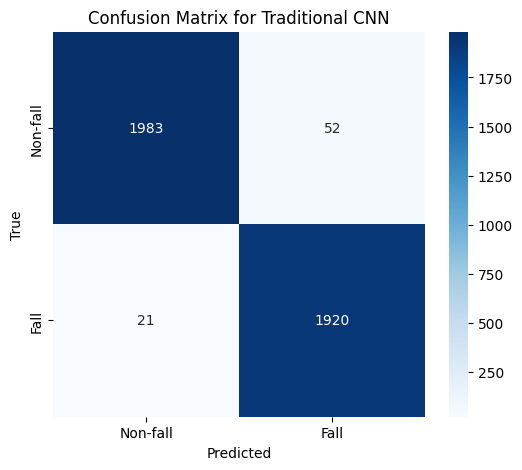

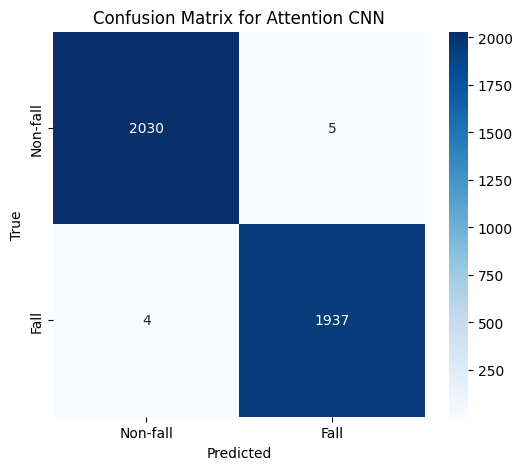

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, model_name="Model"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-fall", "Fall"], yticklabels=["Non-fall", "Fall"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion_matrix(cm_traditional, model_name="Traditional CNN")
plot_confusion_matrix(cm_attention, model_name="Attention CNN")


In [ ]:

sample_video_path = r"C:\Users\mgree\Downloads\Dataset CAUCAFall\Dataset CAUCAFall\CAUCAFall\Subject.9\Fall forward\FallForwardS9.avi"


print("\n--- Inference on Sample Video ---")
print("Using Traditional CNN:")
predict_video_action(sample_video_path, model_traditional)

print("\nUsing Attention-Based CNN:")
predict_video_action(sample_video_path, model_attention)

print("\nUsing Ensemble Prediction:")
ensemble_prediction = ensemble_predict(sample_video_path, [model_traditional, model_attention])
print(f"Final Ensemble Prediction: {ensemble_prediction}")



--- Inference on Sample Video ---
Using Traditional CNN:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3